In [17]:
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix
from scipy.sparse.linalg import spsolve, bicgstab, gmres
from scipy.linalg import lu, solve_triangular
import time

In [2]:
# Parameters
n = 64  # Number of grid points
x_min, x_max = -10, 10  # Spatial domain in x
y_min, y_max = -10, 10  # Spatial domain in y
nu = 0.001  # Viscosity
t_span = (0, 4)  # Time span for integration
t_eval = np.arange(0, 4.5, 0.5)  # Time evaluation points

In [3]:
# Spatial grid
x = np.linspace(x_min, x_max, n, endpoint=False)
y = np.linspace(y_min, y_max, n, endpoint=False)
dx = (x_max - x_min) / n
dy = (y_max - y_min) / n
X, Y = np.meshgrid(x, y, indexing='ij')

# Initial vorticity (elliptical Gaussian)
omega0 = np.exp(-X**2 - Y**2 / 20)
omega0_flat = omega0.flatten()

In [4]:
# Wavenumber grids for FFT
kx = np.fft.fftfreq(n, d=(x_max - x_min) / n) * 2 * np.pi
ky = np.fft.fftfreq(n, d=(y_max - y_min) / n) * 2 * np.pi
kx[0] = 1e-6  # Avoid division by zero
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2
K2[0, 0] = 1e-6  # Avoid division by zero at (0,0)

In [5]:
def compute_streamfunction(omega):
    """Compute the streamfunction ψ from vorticity ω using FFT."""
    omega_hat = fft2(omega)
    psi_hat = omega_hat / (-K2)
    psi_hat[0, 0] = 0  # Enforce zero mean for ψ
    psi = np.real(ifft2(psi_hat))
    return psi

def rhs(t, omega_flat):
    """Compute the right-hand side of the vorticity equation."""
    omega = omega_flat.reshape((n, n))

    # Compute streamfunction ψ
    psi = compute_streamfunction(omega)
    
    # Compute derivatives using spectral methods
    omega_hat = fft2(omega)
    psi_hat = fft2(psi)

    # Compute derivatives in Fourier space
    omega_x_hat = 1j * KX * omega_hat
    omega_y_hat = 1j * KY * omega_hat
    psi_x_hat = 1j * KX * psi_hat
    psi_y_hat = 1j * KY * psi_hat

    # Transform back to physical space
    omega_x = np.real(ifft2(omega_x_hat))
    omega_y = np.real(ifft2(omega_y_hat))
    psi_x = np.real(ifft2(psi_x_hat))
    psi_y = np.real(ifft2(psi_y_hat))

    # Compute Jacobian [ψ, ω]
    J = psi_x * omega_y - psi_y * omega_x

    # Compute Laplacian of ω using spectral methods
    laplacian_omega_hat = -K2 * omega_hat
    laplacian_omega = np.real(ifft2(laplacian_omega_hat))

    # RHS of the vorticity equation
    domega_dt = -J + nu * laplacian_omega

    return domega_dt.flatten()

In [6]:
# Integrate in time using solve_ivp
sol = solve_ivp(rhs, t_span, omega0_flat, t_eval=t_eval, method='RK45')

# Extract the solution for vorticity at each time step
A1 = sol.y  # A1 has shape (n*n, number of time steps)

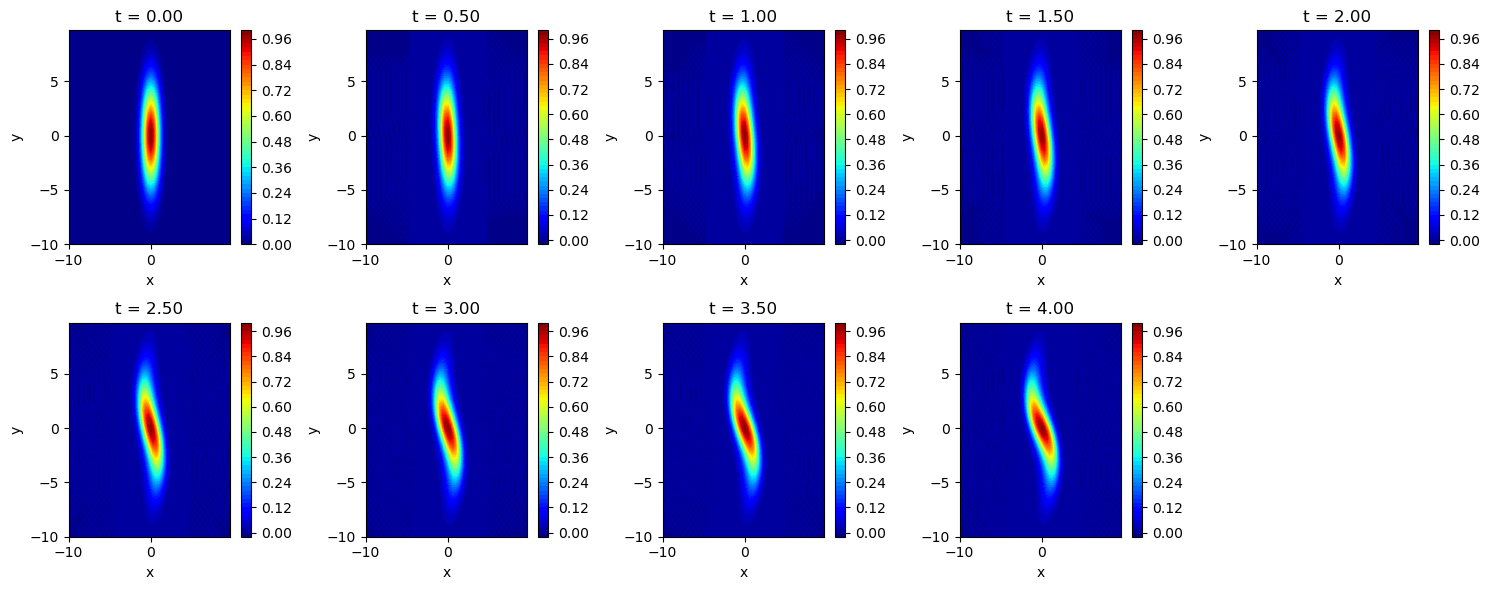

In [7]:
# Plotting the vorticity at different time steps
num_plots = len(t_eval)
fig, axes = plt.subplots(2, int(np.ceil(num_plots / 2)), figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    if i < num_plots:
        omega_t = A1[:, i].reshape((n, n))
        c = ax.contourf(X, Y, omega_t, levels=50, cmap='jet')
        ax.set_title(f't = {t_eval[i]:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        fig.colorbar(c, ax=ax)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

## Part B
- A/b
- LU decomposition
- BICGSTAB
- GMRES

In [18]:
# Parameters
n = 64  # Number of grid points in each dimension
x_min, x_max = -10, 10  # Spatial domain in x
y_min, y_max = -10, 10  # Spatial domain in y
nu = 0.001  # Viscosity
t_span = (0, 4)  # Time span for integration
t_eval = np.arange(0, 4.5, 0.5)  # Time evaluation points

In [19]:

# Spatial grid
x = np.linspace(x_min, x_max, n, endpoint=False)
y = np.linspace(y_min, y_max, n, endpoint=False)
dx = (x_max - x_min) / n
dy = (y_max - y_min) / n
X, Y = np.meshgrid(x, y, indexing='ij')

# Initial vorticity (elliptical Gaussian)
omega0 = np.exp(-X**2 - Y**2 / 20)
omega0_flat = omega0.flatten()


In [20]:
# Construct Laplacian operator A with periodic boundary conditions
def construct_laplacian(n, dx):
    diagonals = [-2 * np.ones(n), np.ones(n - 1), np.ones(n - 1)]
    offsets = [0, -1, 1]
    lap1d = diags(diagonals, offsets, shape=(n, n), format='csr')
    lap1d = lap1d / dx**2

    # Periodic boundary conditions
    lap1d = lap1d.tolil()
    lap1d[0, -1] = 1 / dx**2
    lap1d[-1, 0] = 1 / dx**2
    lap1d = lap1d.tocsr()

    I = eye(n, format='csr')
    A = kron(lap1d, I) + kron(I, lap1d)
    return A

In [32]:

# Laplacian operator
A = construct_laplacian(n, dx)
A = A.tocsr()

# Adjust A(0,0) as per the instructions
A = A.tolil()
A[0, 0] = 2  # Set A(0,0) = 2 instead of -4
A = A.tocsr()

# Convert A to dense matrix for LU decomposition
A_dense = A.toarray()

In [22]:
# Function to solve for psi using different methods
def solve_streamfunction(omega_flat, method='direct'):
    b = omega_flat.copy()
    if method == 'direct':
        start_time = time.time()
        psi_flat = spsolve(A, b)
        elapsed_time = time.time() - start_time
    elif method == 'LU':
        # LU decomposition using scipy.linalg.lu
        start_time = time.time()
        P, L, U = lu(A_dense)
        # Solve Ax = b using forward and backward substitution
        Pb = np.dot(P, b)
        y = solve_triangular(L, Pb, lower=True)
        psi_flat = solve_triangular(U, y)
        elapsed_time = time.time() - start_time
    elif method == 'BiCGSTAB':
        start_time = time.time()
        psi_flat, info = bicgstab(A, b, tol=1e-6, maxiter=1000)
        elapsed_time = time.time() - start_time
        if info != 0:
            print(f"BiCGSTAB did not converge within the maximum number of iterations (info={info})")
    elif method == 'GMRES':
        start_time = time.time()
        psi_flat, info = gmres(A, b, tol=1e-6, restart=50, maxiter=1000)
        elapsed_time = time.time() - start_time
        if info != 0:
            print(f"GMRES did not converge within the maximum number of iterations (info={info})")
    else:
        raise ValueError("Unknown method")
    return psi_flat.reshape((n, n)), elapsed_time

In [23]:
# Lists to store computational times
times = {
    'direct': [],
    'LU': [],
    'BiCGSTAB': [],
    'GMRES': []
}

# Initialize lists to store residuals
residuals = {
    'BiCGSTAB': [],
    'GMRES': []
}

In [24]:
# Callback functions to store residuals
def bicgstab_callback(rk):
    residuals['BiCGSTAB'].append(np.linalg.norm(rk))

def gmres_callback(rk):
    residuals['GMRES'].append(np.linalg.norm(rk))

# Function to compute the RHS of the vorticity equation
def rhs(t, omega_flat):
    """Compute the right-hand side of the vorticity equation."""
    omega = omega_flat.reshape((n, n))

    # Solve for streamfunction ψ
    psi, elapsed_time = solve_streamfunction(omega_flat, method=method)

    # Store computational times
    times[method].append(elapsed_time)

    # Compute derivatives using finite differences with periodic boundaries
    omega_roll_xp = np.roll(omega, -1, axis=0)
    omega_roll_xm = np.roll(omega, 1, axis=0)
    omega_roll_yp = np.roll(omega, -1, axis=1)
    omega_roll_ym = np.roll(omega, 1, axis=1)

    psi_roll_xp = np.roll(psi, -1, axis=0)
    psi_roll_xm = np.roll(psi, 1, axis=0)
    psi_roll_yp = np.roll(psi, -1, axis=1)
    psi_roll_ym = np.roll(psi, 1, axis=1)

    omega_x = (omega_roll_xp - omega_roll_xm) / (2 * dx)
    omega_y = (omega_roll_yp - omega_roll_ym) / (2 * dy)
    psi_x = (psi_roll_xp - psi_roll_xm) / (2 * dx)
    psi_y = (psi_roll_yp - psi_roll_ym) / (2 * dy)

    # Compute Jacobian [ψ, ω]
    J = psi_x * omega_y - psi_y * omega_x

    # Compute Laplacian of ω using finite differences
    laplacian_omega = (omega_roll_xp + omega_roll_xm + omega_roll_yp + omega_roll_ym - 4 * omega) / dx**2

    # RHS of the vorticity equation
    domega_dt = -J + nu * laplacian_omega

    return domega_dt.flatten()


In [25]:
# Run the simulation for different methods
methods = ['direct', 'LU', 'BiCGSTAB', 'GMRES']
results = {}

In [26]:
for method in methods:
    print(f"\nRunning simulation with method: {method}")
    times[method] = []
    residuals['BiCGSTAB'] = []
    residuals['GMRES'] = []

    # For iterative methods, set up callback functions
    if method == 'BiCGSTAB':
        solve_streamfunction_callback = bicgstab_callback
    elif method == 'GMRES':
        solve_streamfunction_callback = gmres_callback
    else:
        solve_streamfunction_callback = None

    # Integrate in time using solve_ivp
    sol = solve_ivp(rhs, t_span, omega0_flat, t_eval=t_eval, method='RK45')

    # Store the results
    results[method] = sol.y.copy()

    # After the first few solves, plot residuals for iterative methods
    if method in ['BiCGSTAB', 'GMRES'] and residuals[method]:
        plt.figure()
        plt.semilogy(residuals[method], label=f'{method} Residuals')
        plt.xlabel('Iteration')
        plt.ylabel('Residual')
        plt.title(f'{method} Residuals Over Time')
        plt.legend()
        plt.grid()
        plt.show()


Running simulation with method: direct

Running simulation with method: LU

Running simulation with method: BiCGSTAB

Running simulation with method: GMRES


In [27]:
# Extract the solutions
A2 = results['direct']  # For A\b method
A3 = results['LU']      # For LU decomposition method

In [28]:
# Print average computational times
for method in methods:
    avg_time = np.mean(times[method])
    print(f"Average computational time per solve for {method}: {avg_time:.6f} seconds")

Average computational time per solve for direct: 0.022057 seconds
Average computational time per solve for LU: 0.511206 seconds
Average computational time per solve for BiCGSTAB: 0.041177 seconds
Average computational time per solve for GMRES: 0.119741 seconds


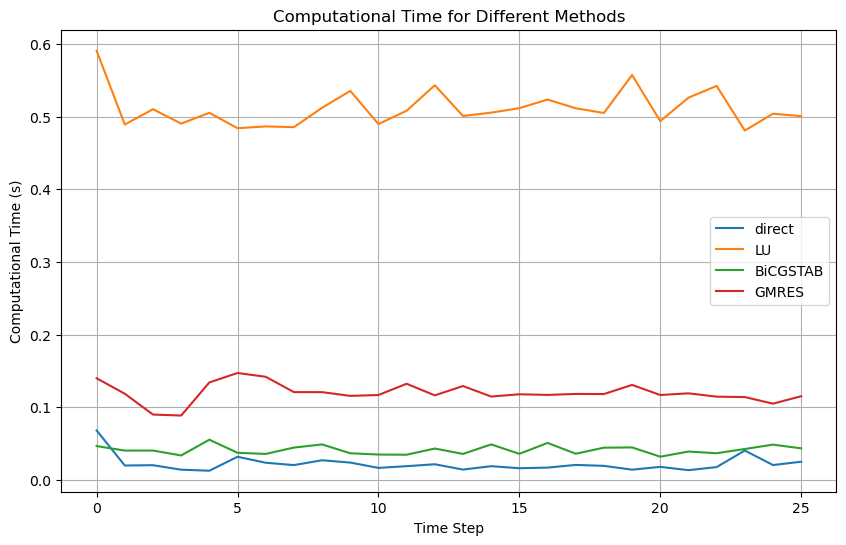

In [29]:
# Plot computational times
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(times[method], label=method)
plt.xlabel('Time Step')
plt.ylabel('Computational Time (s)')
plt.title('Computational Time for Different Methods')
plt.legend()
plt.grid()
plt.show()